In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [154]:
df = pd.read_csv('C:/Users/hello/OneDrive/Documents/GitHub/customer-churn/churn-data/Churn_Modelling.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [156]:
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [157]:
# Feature Engineering
# Binary feature for Balance
df['BalanceZero'] = (df['Balance'] == 0).astype(int)

# Age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65, 75, 85, 95], 
                        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95'])

# Balance to Salary Ratio
df['BalanceToSalaryRatio'] = df['Balance'] / df['EstimatedSalary']

# Interaction feature between NumOfProducts and IsActiveMember
df['ProductUsage'] = df['NumOfProducts'] * df['IsActiveMember']

# Tenure grouping
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 2, 5, 7, 10], 
                           labels=['0-2', '3-5', '6-7', '8-10'])


In [158]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df = pd.get_dummies(df, columns = ['Geography'], drop_first= True)
df['Male_Germany'] = df['Gender'] * df['Geography_Germany'] # 0 for male, 1 for female
df['Male_Spain'] = df['Gender'] * df['Geography_Spain']

df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Exited,BalanceZero,AgeGroup,BalanceToSalaryRatio,ProductUsage,TenureGroup,Geography_Germany,Geography_Spain,Male_Germany,Male_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,...,1,1,36-45,0.000000,1,0-2,False,False,0,0
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,...,0,0,36-45,0.744677,1,0-2,False,True,0,0
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,...,1,0,36-45,1.401375,0,8-10,False,False,0,0


In [159]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'BalanceZero', 'AgeGroup',
       'BalanceToSalaryRatio', 'ProductUsage', 'TenureGroup',
       'Geography_Germany', 'Geography_Spain', 'Male_Germany', 'Male_Spain'],
      dtype='object')

In [160]:
features = ['CreditScore', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary',  'Geography_Germany', 'Geography_Spain']
X = df[features]
y = df['Exited'] # target

In [161]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
# Scale and normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [163]:
X_train[:5], X_test[:5]

(array([[ 0.35649971,  0.91324755, -0.6557859 ,  0.34567966, -1.21847056,
          0.80843615,  0.64920267,  0.97481699,  1.36766974, -0.57946723,
         -0.57638802],
        [-0.20389777,  0.91324755,  0.29493847, -0.3483691 ,  0.69683765,
          0.80843615,  0.64920267,  0.97481699,  1.6612541 ,  1.72572313,
         -0.57638802],
        [-0.96147213,  0.91324755, -1.41636539, -0.69539349,  0.61862909,
         -0.91668767,  0.64920267, -1.02583358, -0.25280688, -0.57946723,
          1.73494238],
        [-0.94071667, -1.09499335, -1.13114808,  1.38675281,  0.95321202,
         -0.91668767,  0.64920267, -1.02583358,  0.91539272, -0.57946723,
         -0.57638802],
        [-1.39733684,  0.91324755,  1.62595257,  1.38675281,  1.05744869,
         -0.91668767, -1.54035103, -1.02583358, -1.05960019, -0.57946723,
         -0.57638802]]),
 array([[-0.57749609,  0.91324755, -0.6557859 , -0.69539349,  0.32993735,
          0.80843615, -1.54035103, -1.02583358, -1.01960511,  1.72572

In [164]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [165]:
y_pred = model.predict(X_test)

In [166]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
# 1548 didn't churn correct prediction, 
# 58 type 1 error, would churn, but didn't churn 
# 210 false negatives (type 2) 
# 185 churned and correct prediction

[[1551   56]
 [ 211  182]]


In [167]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.76      0.46      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



In [168]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8665

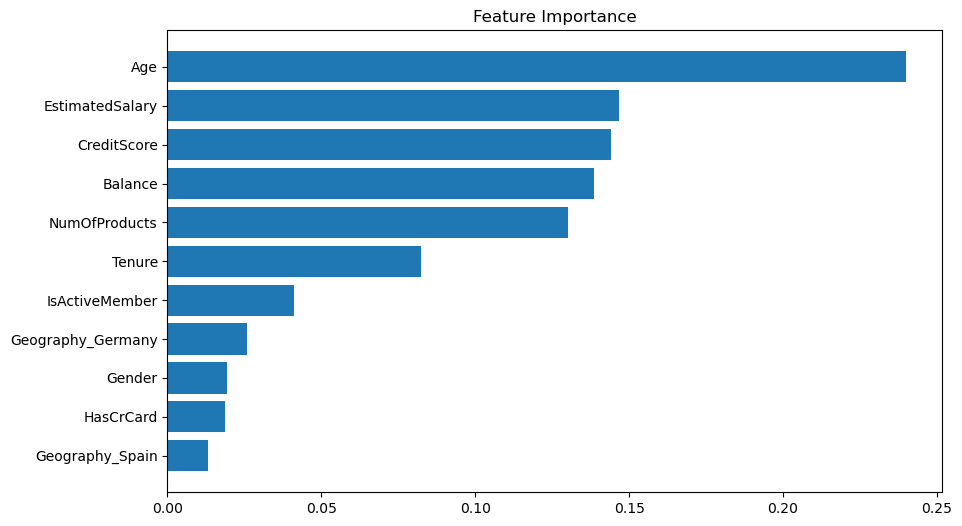

<Figure size 640x480 with 0 Axes>

In [169]:
importances = model.feature_importances_
indices = np.argsort(importances)[::1]
names = [features[i] for i in indices]

plt.figure(figsize= (10, 6))
plt.title('Feature Importance')
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.show()
plt.savefig('./feature_importance.png')

In [170]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(conf_matrix_log_reg, class_report_log_reg, accuracy_log_reg)


[[1543   64]
 [ 314   79]]               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000
 0.811


In [171]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(conf_matrix_knn, class_report_knn, accuracy_knn)


[[1514   93]
 [ 247  146]]               precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000
 0.83


In [172]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

y_pred_gbm = gbm_model.predict(X_test)

conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
class_report_gbm = classification_report(y_test, y_pred_gbm)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)

print(conf_matrix_gbm, class_report_gbm, accuracy_gbm)


[[1543   64]
 [ 201  192]]               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000
 0.8675
